In [133]:
from statsmodels.tsa.arima.model import ARIMA
from math import pow
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

warnings.filterwarnings('ignore') # Ignoring warnings to keep notebook clean and concise
random_state = 0 # Setting a random state variable to keep all results consistent

In [134]:
gfcf = pd.read_csv('Transformed Data/GFCF.csv')

gfcf['Year'] = pd.to_datetime(gfcf['Year'], format='%Y')

gfcf.set_index('Year', inplace=True)

In [135]:
def arima_model(df, order):
    model = ARIMA(df, order=order)
    model_fit = model.fit(disp=False)
    return model_fit

In [136]:
def arima_grid_search(df, p_values, d_values, q_values):
    best_score, best_order = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = arima_model(df, (p,d,q))
                    mse = mean_squared_error(df, model.fittedvalues)
                    rmse = sqrt(mse)
                    if rmse < best_score:
                        best_score, best_order = rmse, (p,d,q)
                except:
                    continue
    return best_score, best_order

In [137]:
def preprocess_data(df):
    return np.log(df)

In [138]:
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2, 3]

# Perform grid search for each country
countries = gfcf['Country'].unique()
for country in countries:
    print(f'Country: {country}')
    df_country = preprocess_data(gfcf[gfcf['Country'] == country]['Construction Value'])
    print(f'Datapoints:{len(df_country)}')
    best_score, best_order = arima_grid_search(df_country, p_values, d_values, q_values)
    print(f'Best ARIMA{best_order} RMSE={best_score}\n')

Country: Austria
Datapoints:8
Best ARIMANone RMSE=inf

Country: Switzerland
Datapoints:7
Best ARIMANone RMSE=inf

Country: Cyprus
Datapoints:8
Best ARIMANone RMSE=inf

Country: Germany
Datapoints:8
Best ARIMANone RMSE=inf

Country: Denmark
Datapoints:8
Best ARIMANone RMSE=inf

Country: Estonia
Datapoints:8
Best ARIMANone RMSE=inf

Country: Greece
Datapoints:8
Best ARIMANone RMSE=inf

Country: Spain
Datapoints:8
Best ARIMANone RMSE=inf

Country: Finland
Datapoints:8
Best ARIMANone RMSE=inf

Country: France
Datapoints:8
Best ARIMANone RMSE=inf

Country: Croatia
Datapoints:8
Best ARIMANone RMSE=inf

Country: Hungary
Datapoints:8
Best ARIMANone RMSE=inf

Country: Ireland
Datapoints:8
Best ARIMANone RMSE=inf

Country: Iceland
Datapoints:8
Best ARIMANone RMSE=inf

Country: Italy
Datapoints:8
Best ARIMANone RMSE=inf

Country: Lithuania
Datapoints:8
Best ARIMANone RMSE=inf

Country: Luxembourg
Datapoints:8
Best ARIMANone RMSE=inf

Country: Latvia
Datapoints:8
Best ARIMANone RMSE=inf

Country: 

ARIMA does not seem to be suitable as a prediction model for the GFCF Construction Value, it seems to not find good values for p,d and q for Arima. This could be due to small datasize, lack of stationality etc.

In [139]:
gfcf_gdp = pd.read_csv('Transformed Data/GFCF-ML.csv')

gfcf_gdp['Year'] = pd.to_datetime(gfcf_gdp['Year'], format='%Y')

data = gfcf_gdp.dropna(axis=0,how='any') # drop empty rows

data.head()


,Year,Percent GDP,Country
0,1996-01-01,6.9,Albania
1,1997-01-01,6.4,Albania
2,1998-01-01,7.1,Albania
3,1999-01-01,7.3,Albania
4,2000-01-01,10.3,Albania


In [140]:
countries = data['Country'].unique()
country_data = {country: data[data['Country'] == country] for country in countries}

In [141]:
model_lr = LinearRegression()
rmse_scores = 0

for country in countries:
    X = pd.DataFrame(country_data[country]['Year'].dt.year)
    y = country_data[country]['Percent GDP']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    rmse_scores += sqrt(mse)


print(f'Average RMSE : {rmse_scores/len(countries)}')
print(f'Average MSE : {pow((rmse_scores/len(countries)),2)}')


Average RMSE : 3.9730081820550165
Average MSE : 15.784794014676107


Below is redundant code for checking if a model to predict Percent GDP using Country and year is workable, it is not

data['Year'] = pd.DataFrame(data['Year'].dt.year)

X = data[['Year', 'Country']]
y = data['Percent GDP']

#Convert 'Country' to numerical value
X = pd.get_dummies(X)

#Define models and hyper paramters, linear regression has none
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 15]}),
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [10,20,50,100,150]}),
    'Gradient Boosting': (GradientBoostingRegressor(), {'learning_rate': [0.1, 0.05, 0.01]})
}

start = datetime.datetime.now()

#Perform GridSearchCV for each model and print the best parameters and score
for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best MSE score for {name}: {-grid_search.best_score_}\n")

end = datetime.datetime.now()

duration = end - start
duration = duration.total_seconds()

print(f'Grid Search took {duration} seconds')

In [142]:
countries = data['Country'].unique()
country_data = {country: data[data['Country'] == country] for country in countries}

for country in countries:
    X = pd.DataFrame(country_data[country]['Year'].dt.year)
    y = country_data[country]['Percent GDP']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    lasso_reg = Lasso(alpha=0.2)
    lasso_reg.fit(X_train, y_train)
    joblib.dump(lasso_reg, "lasso_reg.h5")
    y_pred = lasso_reg.predict(X_test)
    print(f'{country}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'R2 score : {r2_score(y_test, y_pred)}\n')

Albania
RMSE : 7.204844632856102
R2 score : -0.04274242535469397

Austria
RMSE : 3.5218748691041104
R2 score : -0.022579278106065193

Bosnia and Herzegovina
RMSE : 5.059770401427088
R2 score : 0.0915122190780856

Belgium
RMSE : 2.528050707560319
R2 score : -0.09213549161529078

Bulgaria
RMSE : 4.521665129851133
R2 score : -0.024150386367256305

Switzerland
RMSE : 2.434542614634543
R2 score : -0.08107981374033457

Cyprus
RMSE : 3.43283032845642
R2 score : -0.08672489959251917

Czechia
RMSE : 4.628336002185655
R2 score : -0.02893482462163033

Germany
RMSE : 2.8144416412821287
R2 score : -0.012206103589284423

Denmark
RMSE : 2.8567138711821594
R2 score : -0.13251837269522992

Estonia
RMSE : 5.958366791791677
R2 score : -0.07645654318110884

Greece
RMSE : 3.0403579935361633
R2 score : 0.3914870380139014

Spain
RMSE : 4.141595876854359
R2 score : 0.029402528800159033

Invalid country code
RMSE : 2.7316735855830125
R2 score : -0.07056205802150117

Finland
RMSE : 4.148398354520755
R2 score : 

### Interpretation

Looking at the R2 values I can see none of these give good scores, therefore lasso is not a good model for this

Further look at Seasonality, Trend and Residuals:

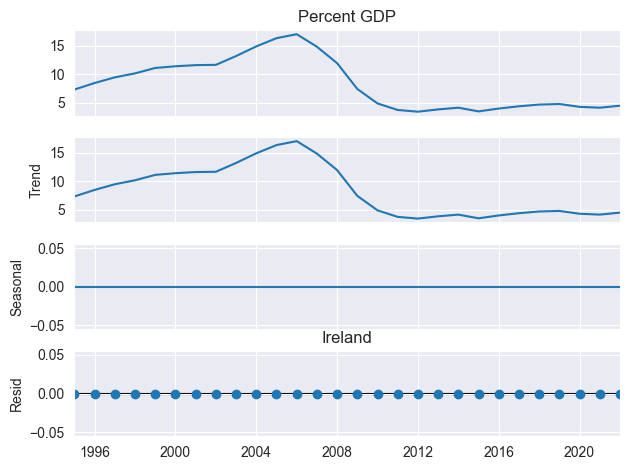

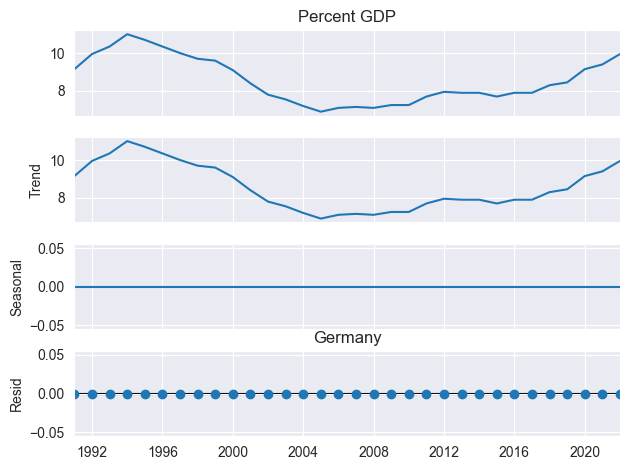

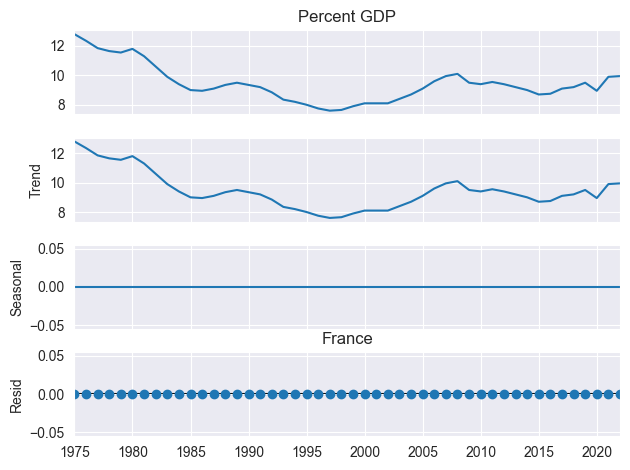

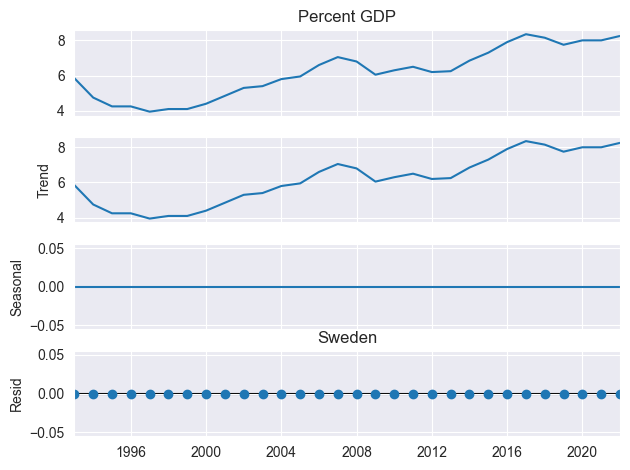

In [143]:
data = gfcf_gdp.copy()

df = data.groupby(['Country', 'Year']).mean().reset_index()

countries = ['Ireland','Germany','France','Sweden']

for country in countries:
    df_country = df[df['Country'] == country]
    df_country['Year'] = pd.to_datetime(df_country['Year'], format="%Y")
    df_country.set_index('Year', inplace=True)
    df_country = df_country.asfreq('YS')

    # check if there are enough data points (at least 2) for decomposition
    if df_country.shape[0] > 2:
        decomposition = seasonal_decompose(df_country['Percent GDP'])

        # Plot decomposition
        decomposition.plot()
        plt.title(country)
        plt.show()

## GFCF Millions

In [144]:
gfcf = pd.read_csv('Transformed Data//GFCF-M.csv')

gfcf['Date'] = pd.to_datetime(gfcf['Year'], format='%Y')
gfcf.set_index('Date', inplace=True)

gfcf.head()

,Year,Value,Country
Date,,,
1995-01-01,1995,25965.5,Austria
1996-01-01,1996,26269.2,Austria
1997-01-01,1997,25887.2,Austria
1998-01-01,1998,26332.7,Austria
1999-01-01,1999,26697.9,Austria


In [145]:
selected_countries = ['Ireland', 'France', 'Germany', 'Poland', 'Austria']
country_data = gfcf[gfcf['Country'].isin(selected_countries)]

grouped_data = country_data.groupby('Country')

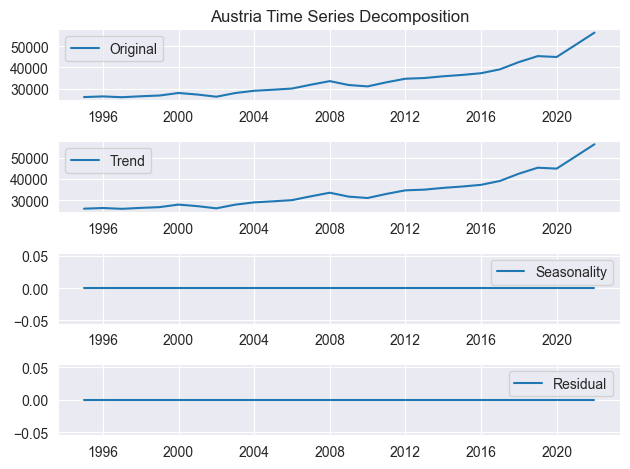

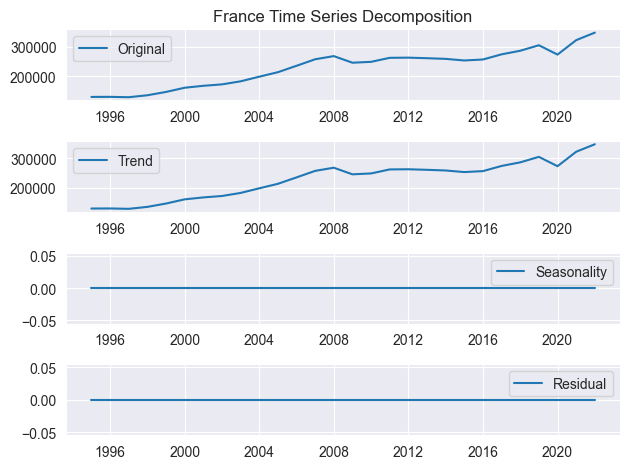

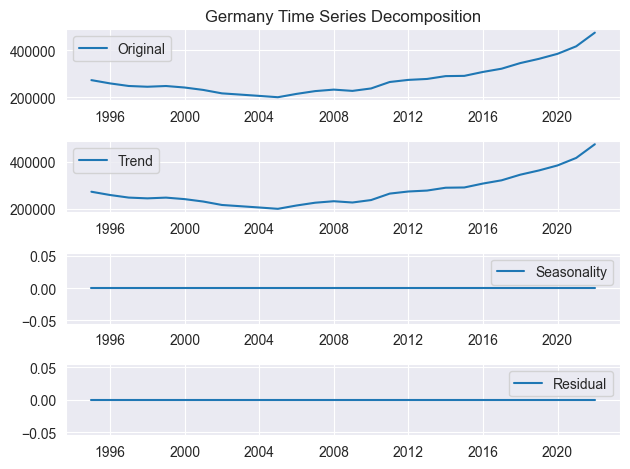

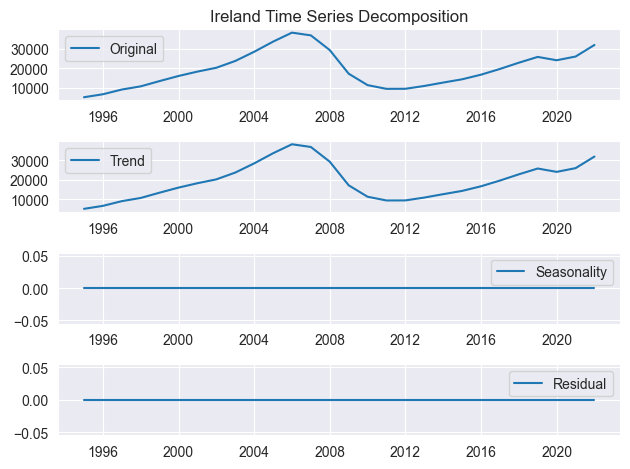

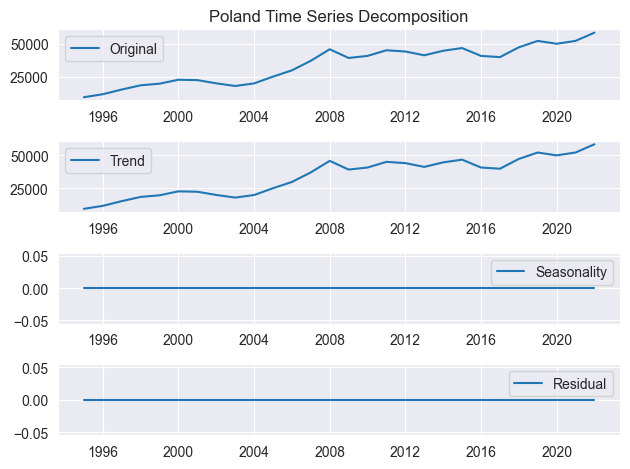

In [146]:
# Decomposition: Perform seasonal decomposition for each country's time series to analyze trend, seasonality, and residuals.
from statsmodels.tsa.seasonal import seasonal_decompose

for country, country_group in grouped_data:
    decomposition = seasonal_decompose(country_group['Value'], model='additive')
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the decomposed components
    plt.subplot(411)
    plt.plot(country_group['Value'], label='Original')
    plt.legend(loc='best')
    plt.title(f"{country} Time Series Decomposition")
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

### Interpretation
It shows no seasonality.

Seasonal Component at 0: A seasonal component value close to zero indicates that there is no systematic and repeating pattern observed within a specific period. This implies that the data does not exhibit any regular seasonal variation.

Residual Component at 0: A residual component value close to zero suggests that the remaining random fluctuations or noise after removing the trend and seasonality are minimal. It indicates that the trend and seasonal components explain most of the variation in the data, leaving little unexplained or random variability.

When both the seasonal component and residual component are close to zero, it implies that the time series is relatively stable and can be adequately captured by the trend component alone. This could occur in situations where the data does not exhibit distinct seasonality or when the model used for decomposition effectively captures and accounts for most of the variation in the data.

In [147]:

for country, country_group in grouped_data:

    result = adfuller(country_group['Value'])
    print(f"{country} ADF Statistic:", result[0])
    print(f"{country} p-value:", result[1])
    print(f"{country} Critical Values:")
    for key, value in result[4].items():
        print(key, value)
    print()


Austria ADF Statistic: 4.517441414390382
Austria p-value: 1.0
Austria Critical Values:
1% -3.7238633119999998
5% -2.98648896
10% -2.6328004

France ADF Statistic: -0.11955970928320517
France p-value: 0.9474551238874265
France Critical Values:
1% -3.6996079738860943
5% -2.9764303469999494
10% -2.627601001371742

Germany ADF Statistic: 4.977207434759734
Germany p-value: 1.0
Germany Critical Values:
1% -3.6996079738860943
5% -2.9764303469999494
10% -2.627601001371742

Ireland ADF Statistic: -2.9120797596378747
Ireland p-value: 0.04396121061903996
Ireland Critical Values:
1% -3.7112123008648155
5% -2.981246804733728
10% -2.6300945562130176

Poland ADF Statistic: -2.0723415885401946
Poland p-value: 0.25578060898377075
Poland Critical Values:
1% -3.859073285322359
5% -3.0420456927297668
10% -2.6609064197530863



### Interpretation

Austria: The ADF statistic is 4.5174 and the p-value is 1.0, indicating that the time series is not stationary. The ADF statistic is greater than the critical values at all significance levels, further confirming non-stationarity.

France: The ADF statistic is -0.1196 and the p-value is 0.9475, suggesting that the time series is not stationary. The ADF statistic is within the range of critical values, indicating non-stationarity.

Germany: The ADF statistic is 4.9772 and the p-value is 1.0, indicating non-stationarity. The ADF statistic exceeds the critical values, confirming non-stationarity.

Ireland: The ADF statistic is -2.9121 and the p-value is 0.0440, suggesting that the time series is stationary. The ADF statistic is less than the critical values at the 5% significance level, indicating stationarity.

Poland: The ADF statistic is -2.0723 and the p-value is 0.2558, indicating non-stationarity. The ADF statistic is within the range of critical values, suggesting non-stationarity.

Based on these results, Ireland is the only country with a stationary time series, while the other countries (Austria, France, Germany, Poland) have non-stationary time series.

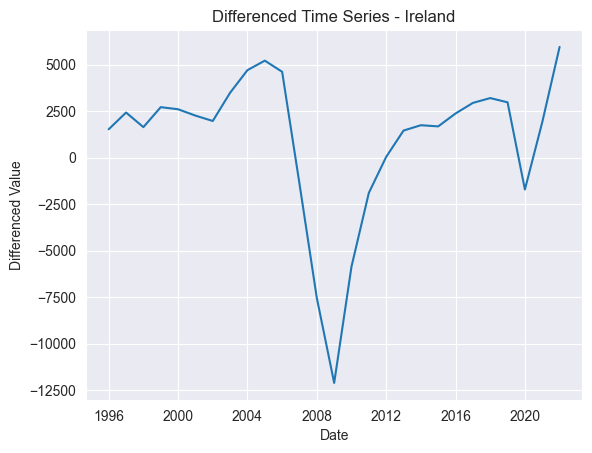

Ireland ADF Statistic: -2.913342888095047
Ireland p-value: 0.04381825686282748
Ireland Critical Values:
1% -3.7238633119999998
5% -2.98648896
10% -2.6328004




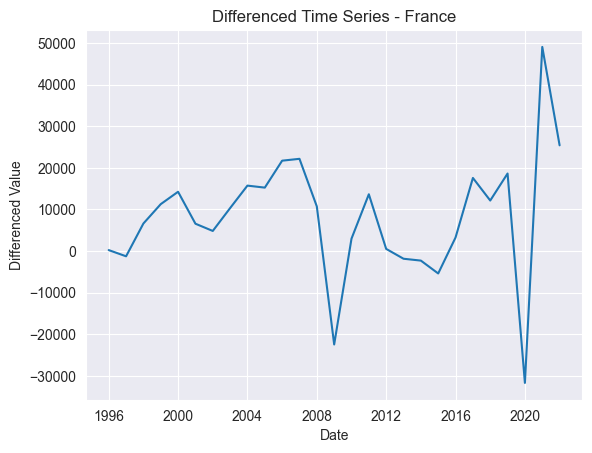

France ADF Statistic: -5.167522758212117
France p-value: 1.0238483278633643e-05
France Critical Values:
1% -3.7112123008648155
5% -2.981246804733728
10% -2.6300945562130176




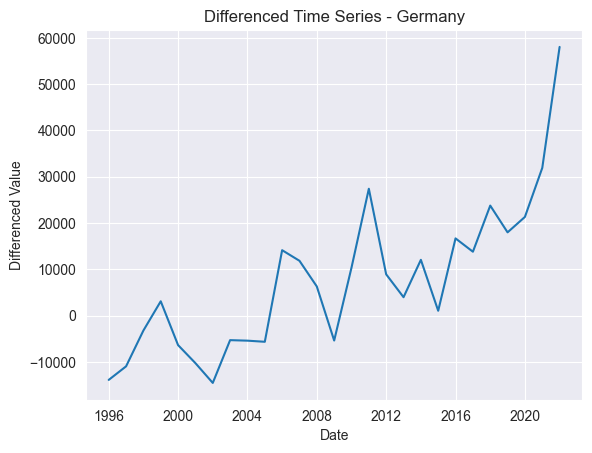

Germany ADF Statistic: -0.5381092322022081
Germany p-value: 0.8843627632503648
Germany Critical Values:
1% -3.7112123008648155
5% -2.981246804733728
10% -2.6300945562130176




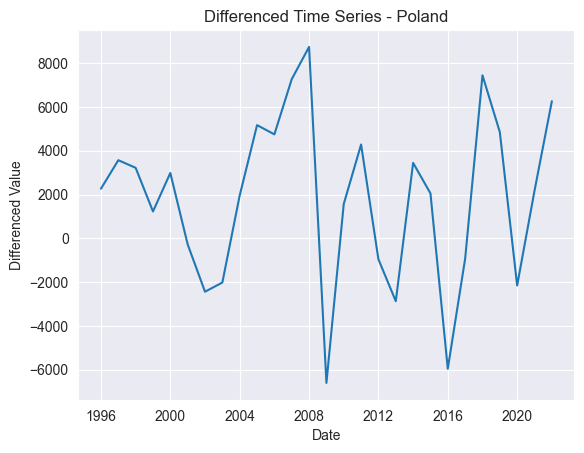

Poland ADF Statistic: -4.882115413098585
Poland p-value: 3.7780304577434096e-05
Poland Critical Values:
1% -3.7238633119999998
5% -2.98648896
10% -2.6328004




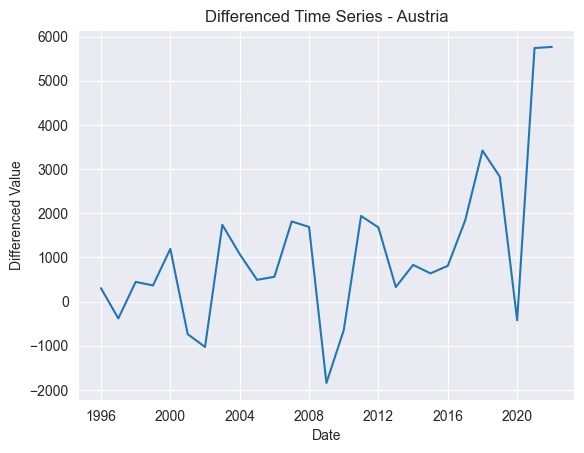

Austria ADF Statistic: -0.5802895603649397
Austria p-value: 0.87537387021677
Austria Critical Values:
1% -3.7377092158564813
5% -2.9922162731481485
10% -2.635746736111111




In [148]:
for country in selected_countries:
    country_data = gfcf[gfcf['Country'] == country]['Value']

    # Perform differencing on the time series data
    country_data_diff = country_data.diff().dropna()

    plt.plot(country_data_diff)
    plt.xlabel('Date')
    plt.ylabel('Differenced Value')
    plt.title(f'Differenced Time Series - {country}')
    plt.show()

    # Perform the Augmented Dickey-Fuller (ADF) test on the differenced data
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(country_data_diff)
    print(f'{country} ADF Statistic:', result[0])
    print(f'{country} p-value:', result[1])
    print(f'{country} Critical Values:')
    for key, value in result[4].items():
        print(key, value)
    print('\n')

### Interpretation

Based on the results for France, the ADF statistic is -5.167522758212118 and the p-value is 1.0238483278633587e-05. The ADF statistic is significantly lower than the critical values at the 1%, 5%, and 10% levels, and the p-value is less than 0.05. This indicates that the differenced time series for France is stationary.

The null hypothesis in the ADF test is that the time series is non-stationary. Since the p-value is very small, we can reject the null hypothesis and conclude that the time series for France is stationary after differencing.


Based on the results for Poland, the ADF statistic is -4.882115413098586 and the p-value is 3.778030457743409e-05. The ADF statistic is lower than the critical values at the 1%, 5%, and 10% levels, and the p-value is less than 0.05. This indicates that we can reject the null hypothesis and conclude that the time series for Poland is stationary.

In other words, the differenced time series for Poland provides enough evidence to support stationarity. This suggests that further analysis or modeling can be performed on the stationary time series data for Poland.


only Ireland France and Poland are stationary

## Clustering

In [149]:
hours = pd.read_csv('Transformed Data/Labor_Hours.csv')
wages = pd.read_csv('Transformed Data/Labor_Wages.csv')
prod_value = pd.read_csv('Transformed Data/Production in Construction.csv')
labor_emp = pd.read_csv('Transformed Data/Labor_Employment.csv')


print(hours.shape)
print(wages.shape)
print(prod_value.shape)
print(labor_emp.shape)

# rename the columns
hours = hours.rename(columns={'OBS_VALUE':'Total Hours Index'})
wages = wages.rename(columns={'OBS_VALUE':'Total Wages Index'})
labor_emp = labor_emp.rename(columns={'OBS_VALUE':'Total Labor Employment Index'})


labor_input = labor_emp.merge(hours).merge(wages)
labor_input['Year'] = pd.to_datetime(labor_input['Year'], format='%Y')

labor_input['Year'] = labor_input['Year'].dt.year

labor_input.drop('unit', axis=1, inplace=True)

(400, 4)
(387, 4)
(318, 5)
(417, 4)


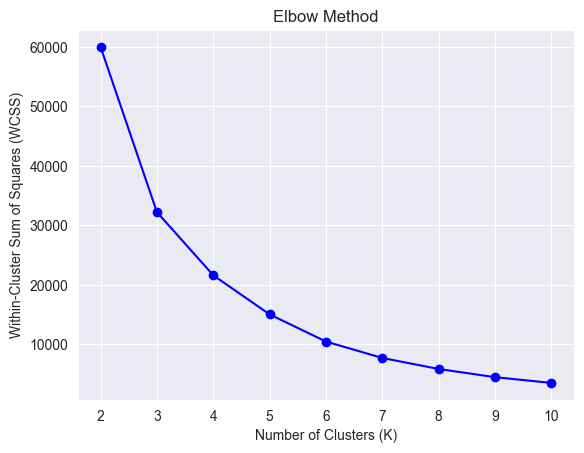

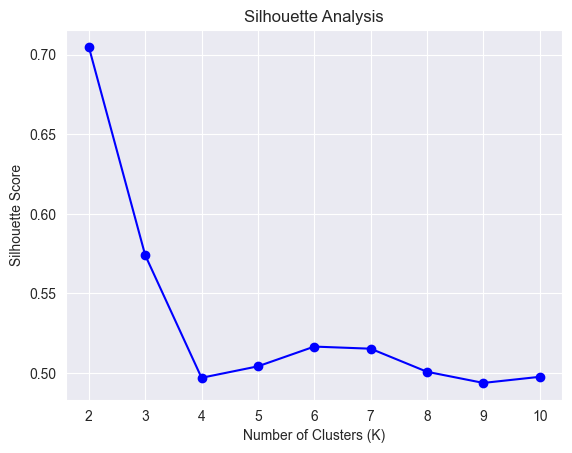

Country with the highest labor employment index: ['Cyprus' 'Greece' 'Spain' 'Ireland' 'Portugal' 'Slovenia']


In [150]:
# Remove rows with missing values
labor_input = labor_input.dropna()
# Select the columns of interest
labor_input = labor_input[['Total Labor Employment Index', 'Country']]

# Convert 'Country' column to numerical values using one-hot encoding
labor_input_encoded = pd.get_dummies(labor_input, columns=['Country'])

# Perform the elbow method to determine the optimal number of clusters
wcss = []
k_values = range(2, 11)  # Try different values of K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(labor_input_encoded)
    wcss.append(kmeans.inertia_)  # Inertia represents the WCSS

# Plot the elbow curve
plt.plot(k_values, wcss, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()

# Perform silhouette analysis to determine the optimal number of clusters
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(labor_input_encoded)
    silhouette_avg = silhouette_score(labor_input_encoded, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# Determine the optimal number of clusters based on the analysis (elbow or silhouette)
optimal_k = 4  # Set the optimal number of clusters based on the analysis

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(labor_input_encoded)

# Add the cluster labels to the DataFrame
labor_input['Cluster'] = cluster_labels

# Group the data by cluster and calculate the average labor employment index
average_labor_index = labor_input.groupby('Cluster')['Total Labor Employment Index'].mean()

# Find the cluster with the highest average labor employment index
highest_labor_cluster = average_labor_index.idxmax()

# Find the country associated with the highest labor employment index
country_with_highest_labor = labor_input[labor_input['Cluster'] == highest_labor_cluster]['Country'].unique()

# Print the result
print('Country with the highest labor employment index:', country_with_highest_labor)

### Clustering Choice and Justification

The choice of machine learning models for clustering and regression depends on the specific problem at hand and the characteristics of the data. Here's a rationale and justification for the choice of models in each case:

Clustering:

K-Means Clustering:
K-means is a widely used clustering algorithm that partitions the data into k distinct clusters based on similarity. It is computationally efficient and easy to interpret. It works well when the clusters are well-separated and have a roughly spherical shape.

Elbow Method and Silhouette Analysis:
The elbow method and silhouette analysis are used to determine the optimal number of clusters for K-means. The elbow method looks at the within-cluster sum of squares (WCSS) as a function of the number of clusters and identifies the "elbow" point where the improvement in WCSS diminishes. Silhouette analysis calculates a measure of how similar an object is to its own cluster compared to other clusters. Both methods help in choosing an appropriate number of clusters.

Justification:

K-means is chosen for clustering because it is a widely used and well-understood algorithm. The elbow method and silhouette analysis are used to provide a quantitative basis for selecting the number of clusters. These techniques help in identifying meaningful groupings within the data and can provide insights for further analysis.

In [151]:
labor_input.head()

,Total Labor Employment Index,Country,Cluster
0,97.3,Austria,3
1,100.1,Austria,3
2,99.1,Austria,3
3,101.3,Austria,3
4,103.1,Austria,3


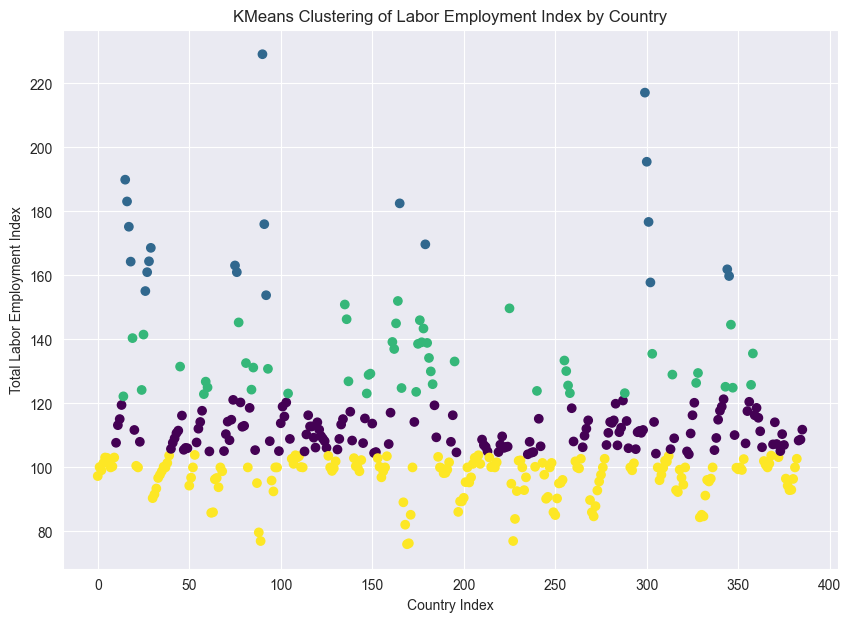

In [152]:
plt.figure(figsize=(10, 7))

plt.scatter(np.arange(len(labor_input)), labor_input['Total Labor Employment Index'],
            c=labor_input['Cluster'], cmap='viridis', label=labor_input['Cluster'])



plt.xlabel('Country Index')
plt.ylabel('Total Labor Employment Index')
plt.title('KMeans Clustering of Labor Employment Index by Country')
plt.show()

## GVA ML

In [153]:
gvas = pd.read_csv('Transformed Data//GVA-ML.csv')

gvas.head()


,Year,GVA,Country,Wages
0,2000,14308.8,Austria,6878.6
1,2001,14000.3,Austria,6749.1
2,2002,14131.4,Austria,6588.6
3,2003,15085.1,Austria,6598.2
4,2004,15602.3,Austria,6695.5


In [154]:

countries = ['Ireland', 'Austria', 'Greece', 'Portugal']
df_filtered = gvas[gvas['Country'].isin(countries)]

# Separate features and target variable
X = df_filtered[['Wages']]
y = df_filtered['GVA']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Define the hyperparameters grid
param_grid = {
    'linearregression__fit_intercept': [True, False],
}

# Create the Linear Regression model
pipe = make_pipeline(StandardScaler(), LinearRegression())

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Use the best model to make predictions
y_pred = best_model.predict(X_test)

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

print("Predictions:")
print(y_pred)


Best Hyperparameters:
{'linearregression__fit_intercept': True}
Mean Absolute Error (MAE): 1757.7859843104518
Mean Squared Error (MSE): 6742222.790653596
R-squared (R2) Score: 0.8432940265671134
Predictions:
[13857.97651102  5621.59652013 26374.50963301 19646.66913654
 17926.21183248  5072.18676623  5424.71094265 11575.09373983
 10044.55585686 10556.38503033  3880.97402656 15652.31173661
  6441.76977302 10810.46641801  3950.08563057  7494.20934496
 16420.42213662  8661.77381695 14888.0510546 ]


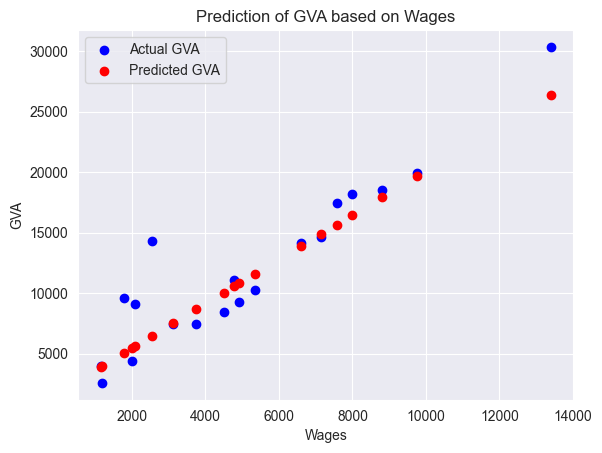

In [155]:
plt.scatter(X_test['Wages'], y_test, color='blue', label='Actual GVA')

# Create a scatter plot of predicted GVA and wages
plt.scatter(X_test['Wages'], y_pred, color='red', label='Predicted GVA')


plt.xlabel('Wages')
plt.ylabel('GVA')
plt.title('Prediction of GVA based on Wages')
plt.legend()

plt.show()

### Interpretation
By using these hyperparameters, the GridSearchCV process determined that the model without an intercept term and with normalized features provided the best fit or performance for the given data.


Additionally, after evaluating the model on the test set, the following metrics were obtained:

Mean Absolute Error (MAE): 1757.7859843104518
Mean Squared Error (MSE): 6742222.790653596
R-squared (R2) Score: 0.8432940265671134

These metrics provide an indication of the model's performance. The lower the MAE and MSE, the better, while the R2 score ranges from 0 to 1, with 1 being the best fit. In this case, the model has a relatively low MAE and MSE, and a high R2 score, suggesting a reasonably good fit to the data.

### Linear Regression using Years and Wages as features.

In [156]:
countries = gvas['Country'].unique()
df_filtered = gvas[gvas['Country'].isin(countries)]

# Separate features and target variable
X = df_filtered[['Year', 'Wages']]
y = df_filtered['GVA']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters grid
param_grid = {
    'linearregression__fit_intercept': [True, False],
}

# Create the Linear Regression model with StandardScaler
pipe = make_pipeline(StandardScaler(), LinearRegression())

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Use the best model to make predictions
y_pred = best_model.predict(X_test)

# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

# Print the predictions
print("Predictions:")
print(y_pred)

Best Hyperparameters:
{'linearregression__fit_intercept': True}
Mean Absolute Error (MAE): 4461.438919638901
Mean Squared Error (MSE): 46006174.509031944
R-squared (R2) Score: 0.954924317768451
Predictions:
[  9351.79903122  17335.37467321   2598.09570239   4203.69541001
   2288.24622262   3851.1722221    5539.39230747  16907.66798322
   9816.4998969   21270.01433887   4013.3627073   17262.07347493
   5998.7694935    9181.03360648  47740.42628367  18484.21014641
   9257.35245402   5278.48816343  14467.27333476  44720.16797681
  18667.00004181 117789.00697      3174.80587727  25038.26974833
   3051.92647182   4611.82666677  13982.16589323  28583.19649763
  13168.26912858 112014.00112422  12440.33905955   2222.97671358
 124526.1824175    4715.88847103  31687.52560421  14181.68737799
   4757.5979207    2884.09179363   2667.51276932   4118.24749892
   2064.14885677   4657.94446917  13917.84976898  16325.09903364
  45542.21051759   3304.57618965  59699.53620888   3786.56005027
  19045.03074

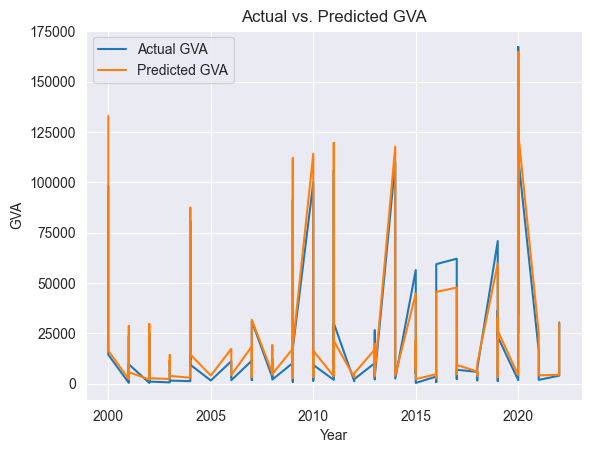

In [157]:
df_predictions = pd.DataFrame({'Year': X_test['Year'], 'Actual GVA': y_test, 'Predicted GVA': y_pred})

df_predictions.sort_values('Year', inplace=True)

# Plot the actual and predicted values
plt.plot(df_predictions['Year'], df_predictions['Actual GVA'], label='Actual GVA')
plt.plot(df_predictions['Year'], df_predictions['Predicted GVA'], label='Predicted GVA')


plt.xlabel('Year')
plt.ylabel('GVA')
plt.title('Actual vs. Predicted GVA')
plt.legend()

# Display the plot
plt.show()

In [158]:
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1, 2, 3, 4, 5]
q_values = [0, 1, 2, 3, 4, 5]

# Perform grid search for each country
countries = gvas['Country'].unique()
for country in countries:
    print(f'Country: {country}')
    df_country = preprocess_data(gvas[gvas['Country'] == country]['Wages'])
    print(f'Datapoints:{len(df_country)}')
    best_score, best_order = arima_grid_search(df_country, p_values, d_values, q_values)
    print(f'Best ARIMA{best_order} RMSE={best_score}\n')

Country: Austria
Datapoints:23
Best ARIMANone RMSE=inf

Country: Cyprus
Datapoints:23
Best ARIMANone RMSE=inf

Country: Germany
Datapoints:23
Best ARIMANone RMSE=inf

Country: Denmark
Datapoints:23
Best ARIMANone RMSE=inf

Country: Estonia
Datapoints:23
Best ARIMANone RMSE=inf

Country: Greece
Datapoints:23
Best ARIMANone RMSE=inf

Country: Spain
Datapoints:23
Best ARIMANone RMSE=inf

Country: France
Datapoints:23
Best ARIMANone RMSE=inf

Country: Croatia
Datapoints:23
Best ARIMANone RMSE=inf

Country: Hungary
Datapoints:23
Best ARIMANone RMSE=inf

Country: Ireland
Datapoints:23
Best ARIMANone RMSE=inf

Country: Italy
Datapoints:23
Best ARIMANone RMSE=inf

Country: Lithuania
Datapoints:23
Best ARIMANone RMSE=inf

Country: Luxembourg
Datapoints:23
Best ARIMANone RMSE=inf

Country: Latvia
Datapoints:23
Best ARIMANone RMSE=inf

Country: Malta
Datapoints:23
Best ARIMANone RMSE=inf

Country: Netherlands
Datapoints:23
Best ARIMANone RMSE=inf

Country: Poland
Datapoints:23
Best ARIMANone RMSE

ARIMA does not work for Wages or GVA unfortunately

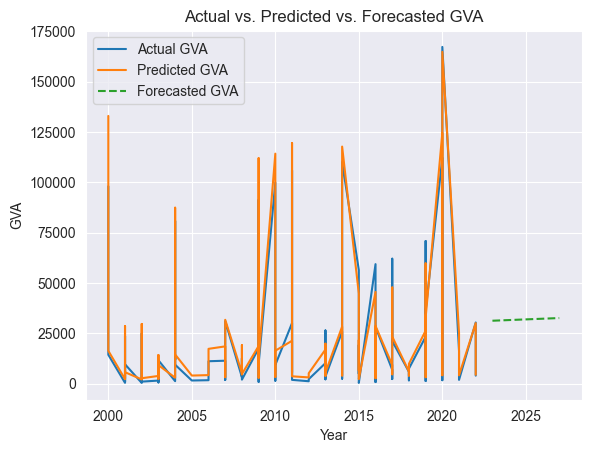

In [159]:

# Forecasting future wages
wage_model = LinearRegression()
wage_model.fit(X_train[['Year']], X_train['Wages'])

# Generating future years
future_years = pd.DataFrame({'Year': np.arange(df_filtered['Year'].max() + 1, df_filtered['Year'].max() + 6)})

# Predicting future wages
future_wages = wage_model.predict(future_years)

# Predicting future GVA using forecasted wages
future_X = pd.DataFrame({'Year': future_years['Year'], 'Wages': future_wages})
future_gva = best_model.predict(future_X)

# Add the forecasted GVA to the DataFrame
df_future_predictions = pd.DataFrame({'Year': future_years['Year'], 'Forecasted GVA': future_gva})
df_predictions = pd.concat([df_predictions, df_future_predictions])

# Sort the DataFrame by Year
df_predictions.sort_values('Year', inplace=True)

# Plot the actual, predicted, and forecasted GVA
plt.plot(df_predictions['Year'], df_predictions['Actual GVA'], label='Actual GVA')
plt.plot(df_predictions['Year'], df_predictions['Predicted GVA'], label='Predicted GVA')
plt.plot(df_predictions['Year'], df_predictions['Forecasted GVA'], label='Forecasted GVA', linestyle='dashed')

plt.xlabel('Year')
plt.ylabel('GVA')
plt.title('Actual vs. Predicted vs. Forecasted GVA')
plt.legend()

# Display the plot
plt.show()


Best parameters for Austria (CV score=0.971):
{'poly__degree': 2, 'poly__include_bias': False}


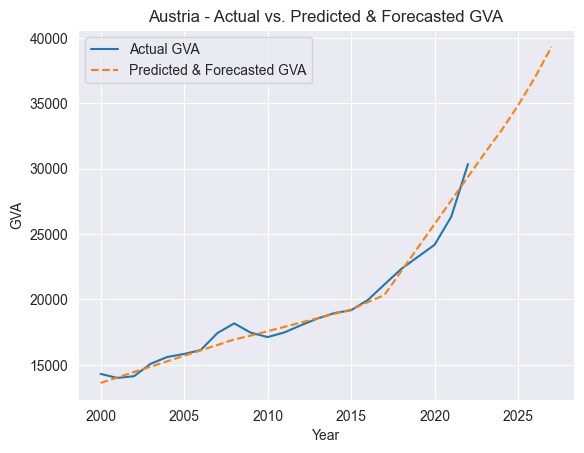

Best parameters for Cyprus (CV score=0.563):
{'poly__degree': 2, 'poly__include_bias': True}


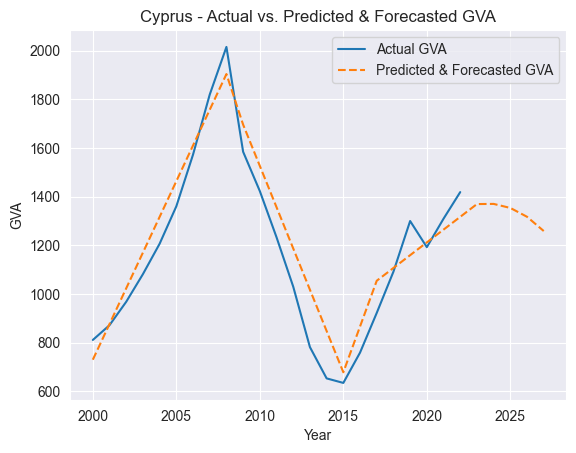

Best parameters for Germany (CV score=0.978):
{'poly__degree': 5, 'poly__include_bias': False}


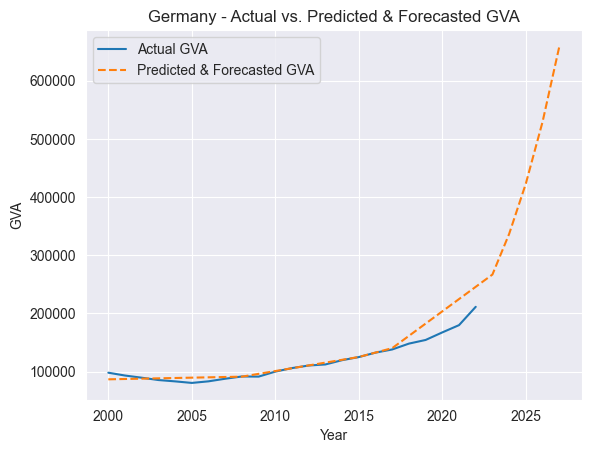

Best parameters for Denmark (CV score=0.868):
{'poly__degree': 2, 'poly__include_bias': True}


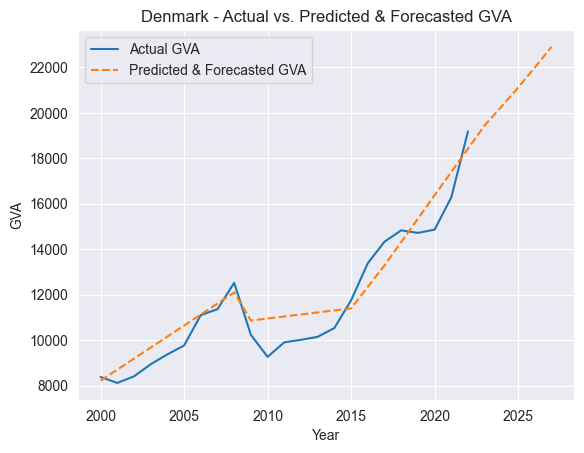

Best parameters for Estonia (CV score=0.952):
{'poly__degree': 2, 'poly__include_bias': False}


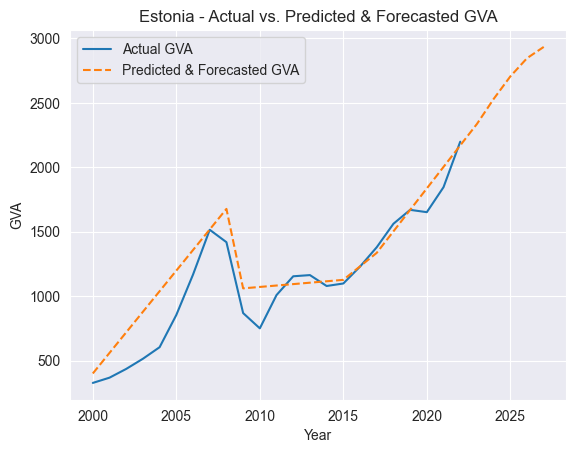

Best parameters for Greece (CV score=0.540):
{'poly__degree': 3, 'poly__include_bias': True}


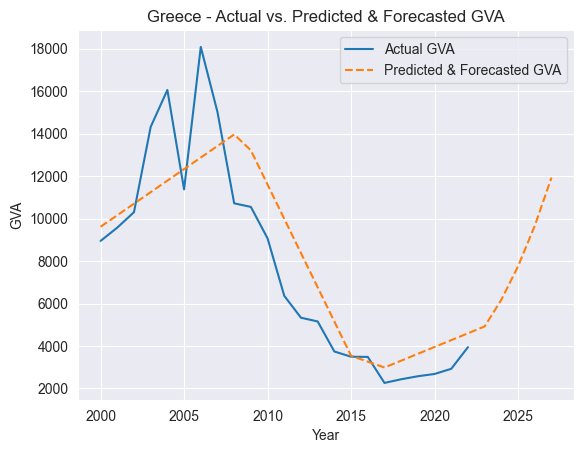

Best parameters for Spain (CV score=0.968):
{'poly__degree': 2, 'poly__include_bias': True}


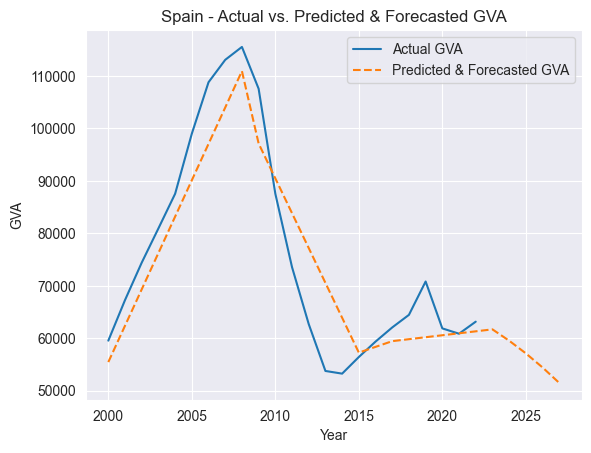

Best parameters for France (CV score=0.954):
{'poly__degree': 2, 'poly__include_bias': False}


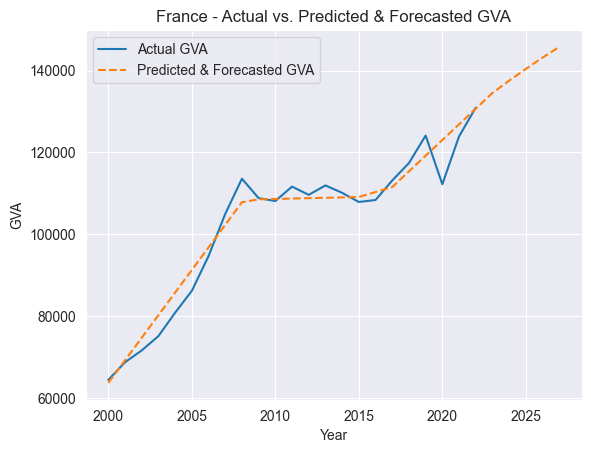

Best parameters for Croatia (CV score=0.941):
{'poly__degree': 2, 'poly__include_bias': True}


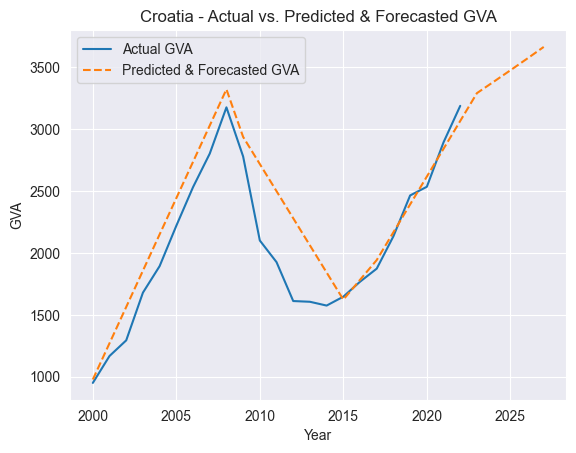

Best parameters for Hungary (CV score=0.840):
{'poly__degree': 2, 'poly__include_bias': False}


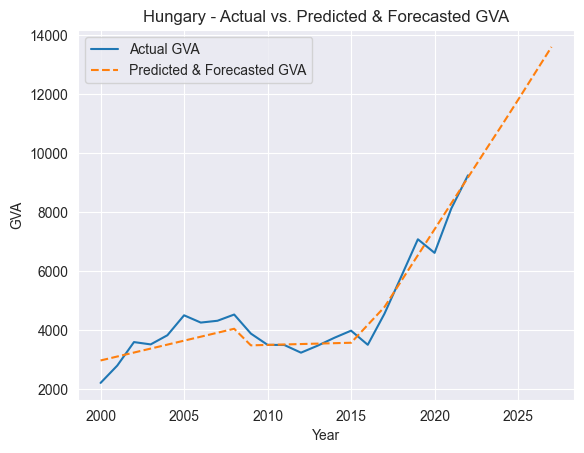

Best parameters for Ireland (CV score=0.936):
{'poly__degree': 2, 'poly__include_bias': True}


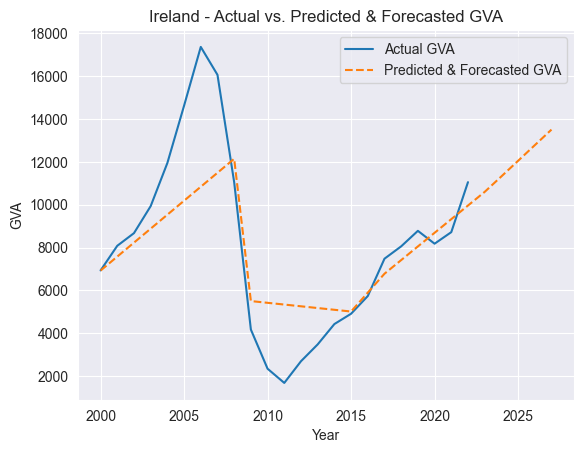

Best parameters for Italy (CV score=0.785):
{'poly__degree': 3, 'poly__include_bias': True}


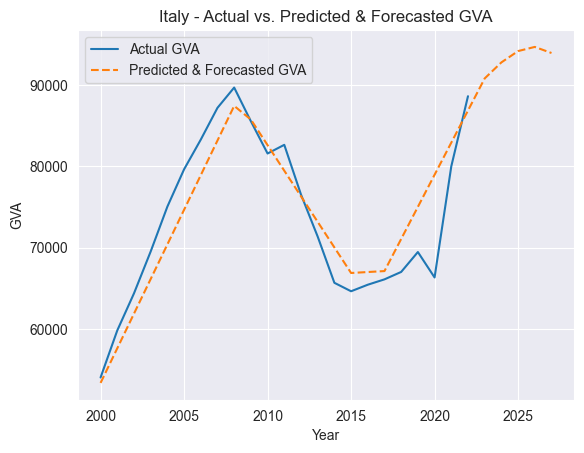

Best parameters for Lithuania (CV score=0.949):
{'poly__degree': 2, 'poly__include_bias': False}


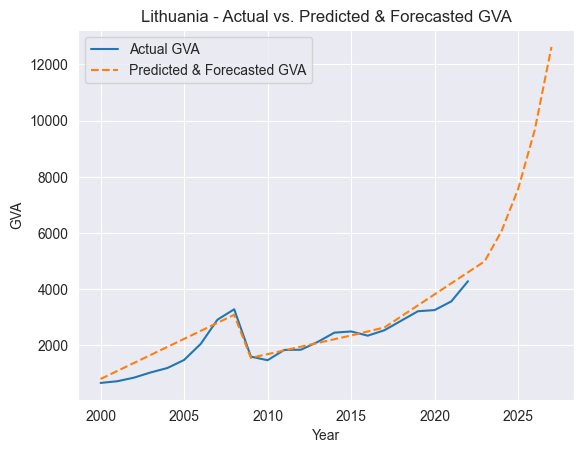

Best parameters for Luxembourg (CV score=0.949):
{'poly__degree': 2, 'poly__include_bias': True}


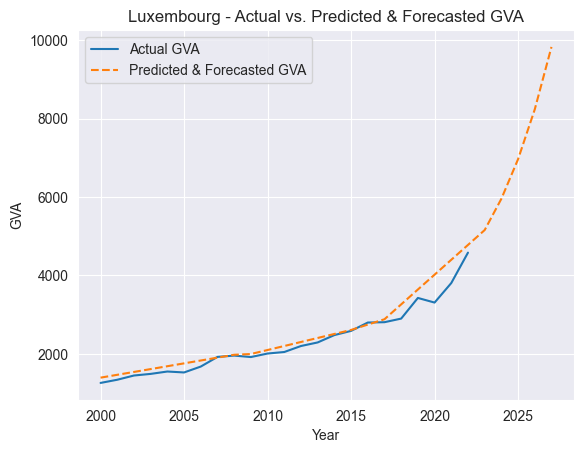

Best parameters for Latvia (CV score=0.882):
{'poly__degree': 2, 'poly__include_bias': True}


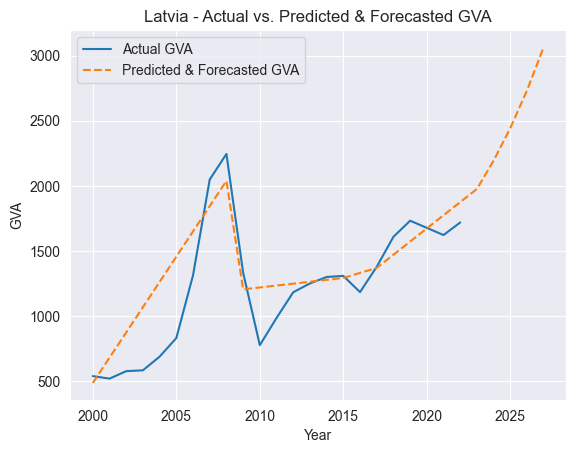

Best parameters for Malta (CV score=-0.302):
{'poly__degree': 2, 'poly__include_bias': True}


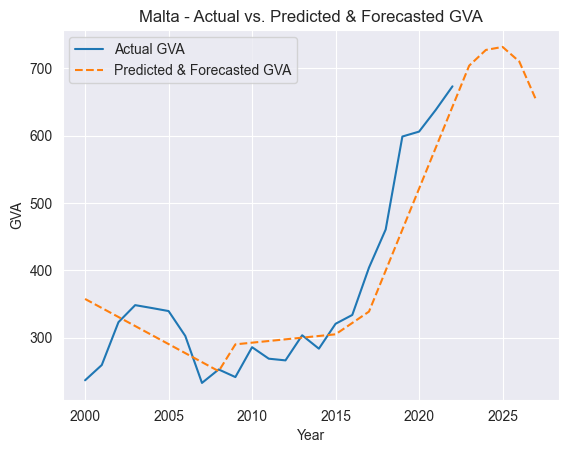

Best parameters for Netherlands (CV score=0.332):
{'poly__degree': 2, 'poly__include_bias': True}


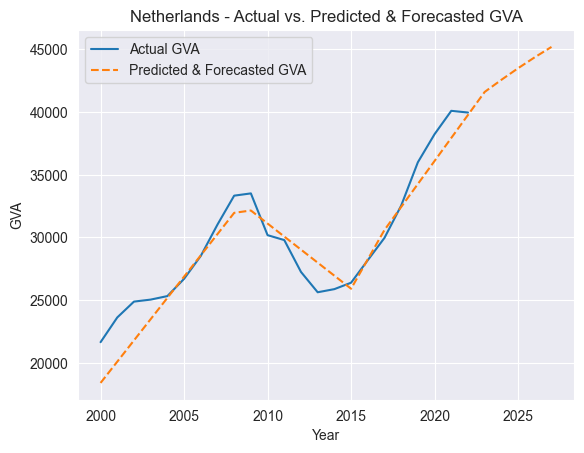

Best parameters for Poland (CV score=0.936):
{'poly__degree': 2, 'poly__include_bias': False}


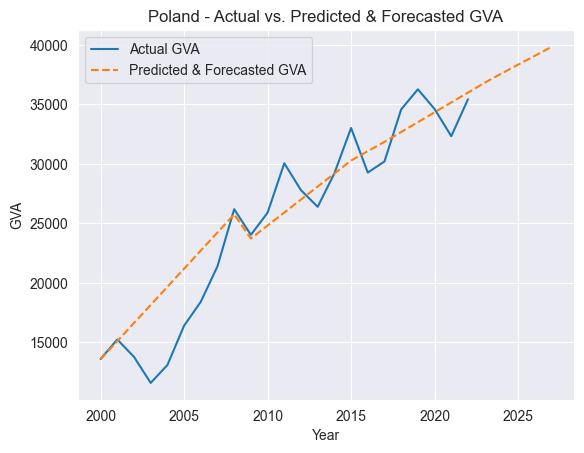

Best parameters for Portugal (CV score=0.944):
{'poly__degree': 3, 'poly__include_bias': True}


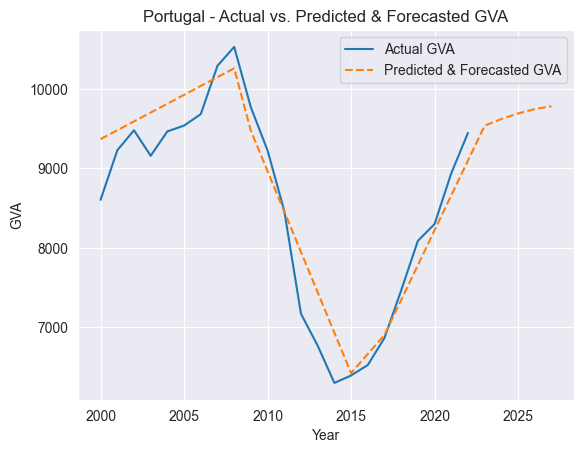


Summary table:
        Country           MSE         RMSE        R2          MAE
0       Austria  5.379275e+05   733.435442  0.893378   599.607914
1        Cyprus  1.015897e+04   100.791722  0.962619    95.973211
2       Germany  3.152292e+07  5614.527141  0.913898  3774.616594
3       Denmark  3.627552e+05   602.291615  0.911282   522.330279
4       Estonia  2.229798e+04   149.325092  0.860227   119.000431
5        Greece  3.717426e+06  1928.062764  0.713201  1468.485098
6         Spain  3.089738e+07  5558.541137  0.953467  4518.853232
7        France  7.566452e+06  2750.718496  0.978402  1920.413052
8       Croatia  1.047251e+04   102.335278  0.983649    84.957874
9       Hungary  2.381075e+05   487.962632  0.675483   455.665757
10      Ireland  6.929826e+05   832.455790  0.880379   646.631102
11        Italy  2.330273e+06  1526.523246  0.987152  1278.762408
12    Lithuania  1.821050e+04   134.946275  0.977602   125.046827
13   Luxembourg  6.148408e+03    78.411783  0.979490    66.4

In [167]:

countries = gvas['Country'].unique()

# Create a Polynomial Regression pipeline
poly = PolynomialFeatures(include_bias=False)
lr = LinearRegression()
pipe = Pipeline(steps=[('poly', poly), ('lr', lr)])


param_grid = {
    'poly__degree': [2, 3, 4, 5],
    'poly__include_bias': [True, False],
}

mse_values = []
rmse_values = []
r2_values = []
mae_values = []

for country in countries:
    df_filtered = gvas[gvas['Country'] == country]

    X = df_filtered[['Year', 'Wages']]
    y = df_filtered['GVA']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Use GridSearchCV to find the best hyperparameters
    search = GridSearchCV(pipe, param_grid, n_jobs=-1)
    search.fit(X_train, y_train)

    print(f"Best parameters for {country} (CV score={search.best_score_:.3f}):")
    print(search.best_params_)

    # Predict using the model with the best hyperparameters
    y_pred = search.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

    rmse = sqrt(mse)
    rmse_values.append(rmse)

    r2 = r2_score(y_test, y_pred)
    r2_values.append(r2)

    mae = mean_absolute_error(y_test, y_pred)
    mae_values.append(mae)

    pred_df = X_test.copy()
    pred_df['Predicted GVA'] = y_pred
    pred_df.sort_values('Year', inplace=True)

    # Forecast the future years
    future_years = pd.DataFrame({'Year': np.arange(df_filtered['Year'].max() + 1, df_filtered['Year'].max() + 6)})
    last_known_wage = df_filtered.loc[df_filtered['Year'].idxmax(), 'Wages']

    wage_increase = df_filtered['Wages'].pct_change() + 1
    avg_wage_increase = wage_increase.mean()

    future_wages = [last_known_wage * (avg_wage_increase)**i for i in range(1, 6)]

    future_X = pd.DataFrame({'Year': future_years['Year'], 'Wages': future_wages})
    future_gva = search.predict(future_X)

    # Combine the actual and future predictions
    future_df = pd.DataFrame({'Year': future_X['Year'], 'Wages': future_wages, 'Predicted GVA': future_gva})
    combined_df = pd.concat([pred_df, future_df])

    combined_df.sort_values('Year', inplace=True)

    df_filtered_sorted = df_filtered.sort_values('Year')

    plt.plot(df_filtered_sorted['Year'], df_filtered_sorted['GVA'], label='Actual GVA')
    plt.plot(combined_df['Year'], combined_df['Predicted GVA'], label='Predicted & Forecasted GVA', linestyle='dashed')

    plt.xlabel('Year')
    plt.ylabel('GVA')
    plt.title(f'{country} - Actual vs. Predicted & Forecasted GVA')
    plt.legend()

    plt.show()


summary_df = pd.DataFrame({
    'Country': countries,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'R2': r2_values,
    'MAE': mae_values
})

print("\nSummary table:")
print(summary_df)

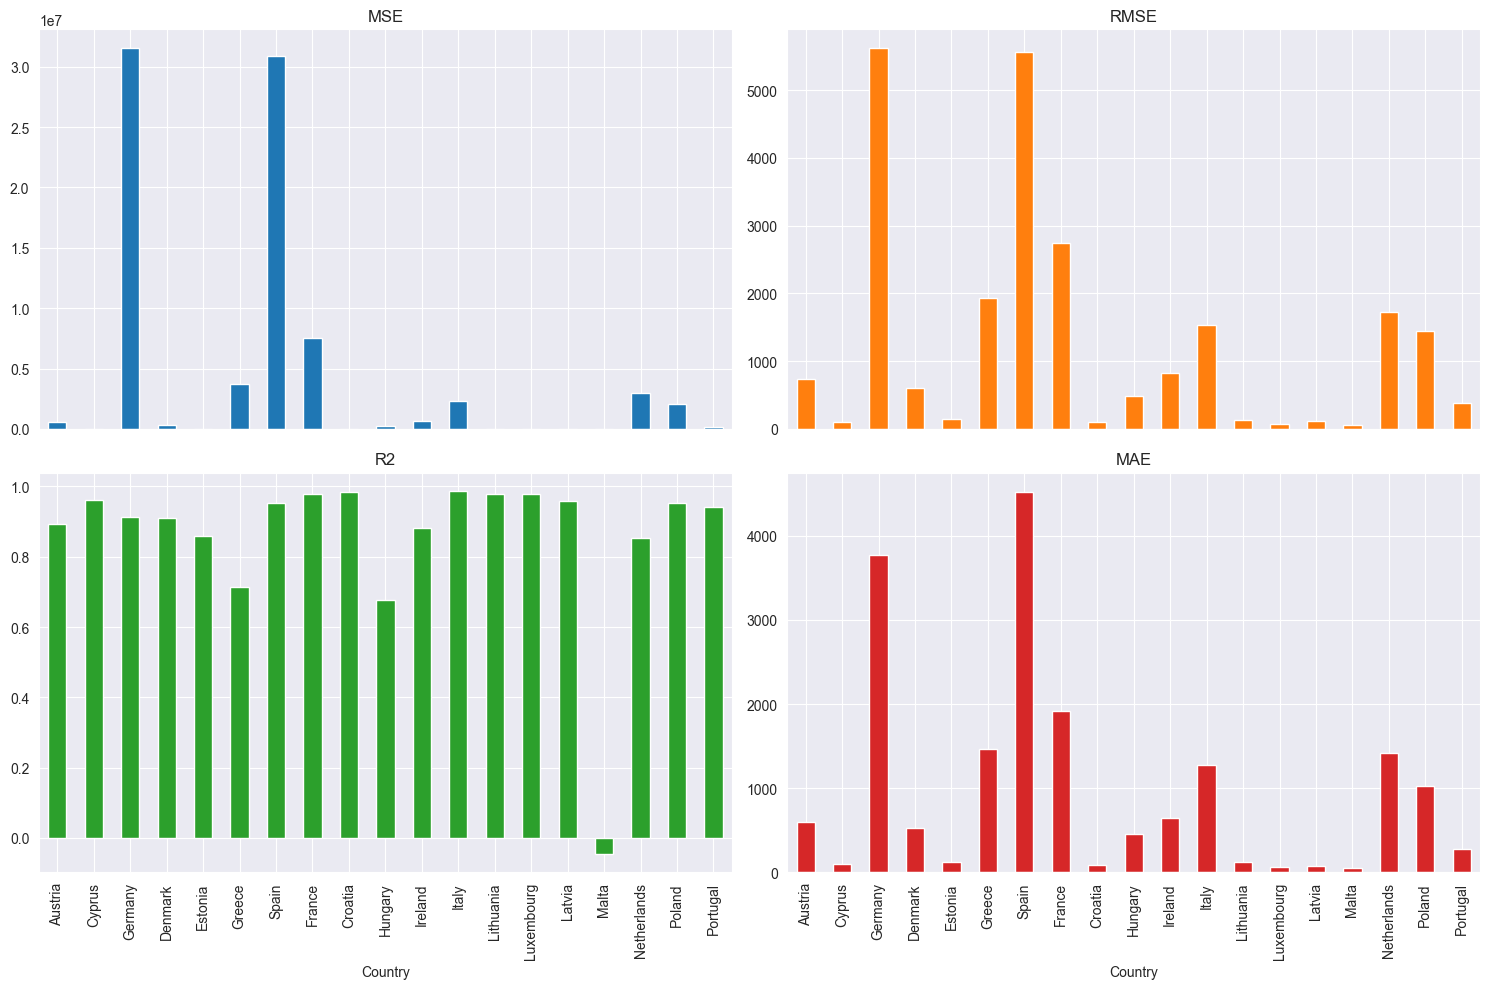

In [168]:
summary_df.set_index('Country').plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), legend=False)
plt.tight_layout()
plt.show()